In [1]:
#importuri
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import imageio.v3 as iio
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense,Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.applications.densenet import DenseNet121
import tensorflow as tf
from sklearn.utils import class_weight
from keras import regularizers
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

,Image,Class
0,12953.png,38
1,02978.png,76
2,10718.png,18
3,01916.png,16
4,15254.png,53


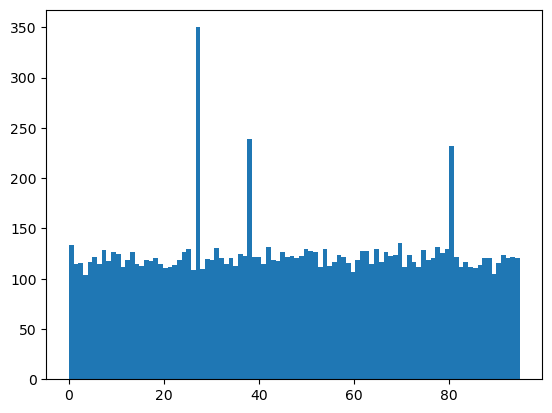

In [2]:
#Load data
path = "/kaggle/input/unibuc-ml-202325/"
train_csv = pd.read_csv(path + "train.csv")
val_csv = pd.read_csv(path + "val.csv")
test_csv = pd.read_csv(path + "test.csv")

#Extracting data
y_train = np.array(train_csv['Class'])
y_val = np.array(val_csv['Class'])

#Convrtim la one-hot-encoded
y_train_encoded = to_categorical(y_train, num_classes=96)
y_val_encoded = to_categorical(y_val, num_classes=96)

display(train_csv.head())
#Vizualizam datele pe care urmeaza sa fie antrenat modelul
plt.hist(x = train_csv['Class'],bins = 96)
plt.show()

In [3]:
#Vizualizam clasele de imagini care au frecventa cea mai mare
frequency_list_train = collections.Counter(train_csv['Class'])
print(frequency_list_train.most_common(3))

frequency_list_val = collections.Counter(val_csv['Class'])
print(frequency_list_val.most_common(3))

[(27, 350), (38, 239), (81, 232)]
[(27, 36), (38, 22), (20, 15)]


**Load X_train, X_val, X_test, apoi convertim la numpy-arrays**

In [4]:
# Load validation images
X_val = np.array([iio.imread(path + "val_images/" + image) for image in val_csv['Image']])

# Load training images
X_train = np.array([iio.imread(path + "train_images/" + image) for image in train_csv['Image']])

# Load test images
X_test = np.array([iio.imread(path + "test_images/" + image) for image in test_csv['Image']])

**Normalizam datele inainte de a fi folosite **

In [5]:
from sklearn import preprocessing

# Reshape pentru a obtine vectori cu shape-ul - numar_de_sample-uri si features
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Creem un obiect de tip StandardScaler
scaler = preprocessing.StandardScaler()

# Sclare fit
scaler.fit(X_train_reshaped)

# Normlizam datele
X_train_normalized = scaler.transform(X_train_reshaped)
X_val_normalized = scaler.transform(X_val_reshaped)
X_test_normalized = scaler.transform(X_test_reshaped)

# Reshape pentru a aduce datele la forma initiala
X_train_normalized = X_train_normalized.reshape(X_train.shape)
X_val_normalized = X_val_normalized.reshape(X_val.shape)
X_test_normalized = X_test_normalized.reshape(X_test.shape)


In [6]:
width, height = X_train[0].shape[:2]
train_samples_no = len(X_train)
val_samples_no = len(X_val)
epochs = 100
batch_size = 50
n_classes = len(frequency_list_train)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4)

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow(
    X_train_normalized,
    y_train_encoded,  # provide the target data
    batch_size=batch_size,
    shuffle=True
)


val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow(
    X_val_normalized,
    y_val_encoded,  # provide the target data
    batch_size=batch_size
)

In [8]:
def build_model():
    model = Sequential()
    model.add(DenseNet121(include_top=False, pooling='avg', weights=None))
    model.add(Dense(2500, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dense(1000, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dense(n_classes, activation='softmax'))

    for layer in model.layers[0].layers:
        layer.trainable = True
    
    return model

In [9]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [10]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [11]:
"""# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

# Create the grid search object
grid_search = GridSearchCV(model, param_grid, cv=3)

# Perform the grid search
grid_search.fit(X_train_normalized, y_train_encoded)

# Get the best hyperparameters
best_params = grid_search.best_params_"""

"# Define the parameter grid\nparam_grid = {\n    'learning_rate': [0.001, 0.01, 0.1],\n    'batch_size': [32, 64, 128]\n}\n\n# Create the grid search object\ngrid_search = GridSearchCV(model, param_grid, cv=3)\n\n# Perform the grid search\ngrid_search.fit(X_train_normalized, y_train_encoded)\n\n# Get the best hyperparameters\nbest_params = grid_search.best_params_"

In [12]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_samples_no // batch_size,
    callbacks=[early_stop,reduce_lr],
    class_weight=class_weights_dict)


Epoch 1/100
240/240 [==============================] - 105s 115ms/step - loss: 6.3313 - acc: 0.1121 - val_loss: 4.4023 - val_acc: 0.1290 - lr: 0.0010
Epoch 2/100
240/240 [==============================] - 26s 108ms/step - loss: 2.9238 - acc: 0.2492 - val_loss: 2.7002 - val_acc: 0.3130 - lr: 0.0010
Epoch 3/100
240/240 [==============================] - 25s 103ms/step - loss: 2.4244 - acc: 0.3587 - val_loss: 2.4850 - val_acc: 0.3420 - lr: 0.0010
Epoch 4/100
240/240 [==============================] - 26s 106ms/step - loss: 2.1106 - acc: 0.4318 - val_loss: 2.3518 - val_acc: 0.3780 - lr: 0.0010
Epoch 5/100
240/240 [==============================] - 26s 106ms/step - loss: 1.8318 - acc: 0.5091 - val_loss: 1.7450 - val_acc: 0.5320 - lr: 0.0010
Epoch 6/100
240/240 [==============================] - 24s 100ms/step - loss: 1.6526 - acc: 0.5527 - val_loss: 1.9107 - val_acc: 0.5060 - lr: 0.0010
Epoch 7/100
240/240 [==============================] - 25s 103ms/step - loss: 1.5256 - acc: 0.5857 - val_

In [13]:
#obtinerea predictiilor pe datele de validare
y_pred = model.predict(X_val_normalized)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_val, y_pred_labels)
print("Accuracy:", accuracy*100)


32/32 [==============================] - 4s 41ms/step
Accuracy: 88.0


In [14]:
misclassified_samples = []
for i in range(len(y_val)):
    if y_pred_labels[i] != y_val[i]:
        misclassified_samples.append((i, y_pred_labels[i], y_val[i]))

for sample in misclassified_samples:
    index = sample[0]
    predicted_label = sample[1]
    true_label = sample[2]
    print(f"Sample {index}: Predicted label: {predicted_label}, True label: {true_label}")


Sample 4: Predicted label: 63, True label: 24
Sample 15: Predicted label: 50, True label: 1
Sample 16: Predicted label: 60, True label: 53
Sample 41: Predicted label: 91, True label: 81
Sample 54: Predicted label: 25, True label: 11
Sample 57: Predicted label: 1, True label: 15
Sample 60: Predicted label: 49, True label: 93
Sample 62: Predicted label: 54, True label: 94
Sample 63: Predicted label: 26, True label: 88
Sample 100: Predicted label: 12, True label: 13
Sample 101: Predicted label: 14, True label: 20
Sample 104: Predicted label: 74, True label: 46
Sample 108: Predicted label: 60, True label: 48
Sample 118: Predicted label: 34, True label: 80
Sample 125: Predicted label: 91, True label: 81
Sample 136: Predicted label: 8, True label: 62
Sample 137: Predicted label: 89, True label: 28
Sample 156: Predicted label: 90, True label: 91
Sample 177: Predicted label: 85, True label: 65
Sample 183: Predicted label: 5, True label: 37
Sample 184: Predicted label: 52, True label: 38
Sample

**Obtinem si reprezentam matricea de confuzie**

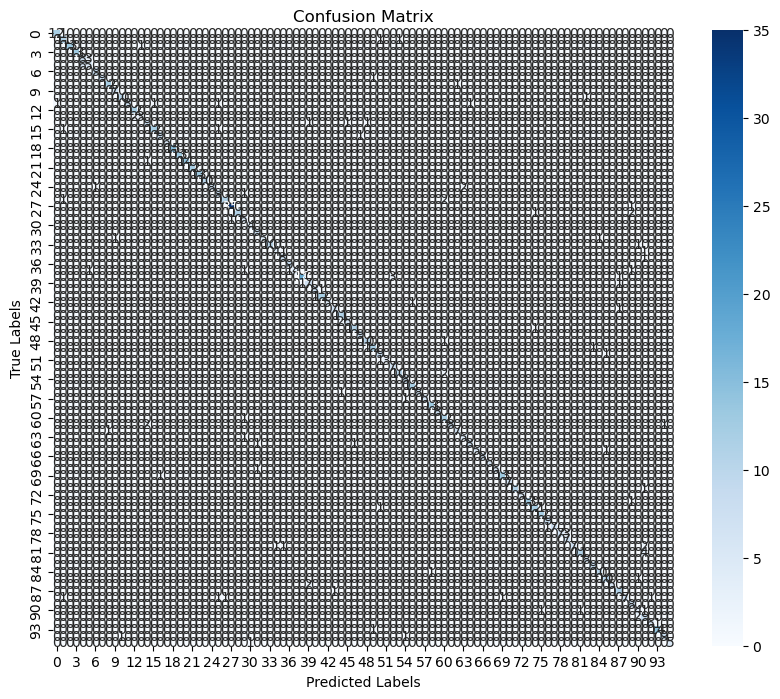

In [15]:
cm = confusion_matrix(y_val, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
sub_pred = model.predict(X_test_normalized)
sub_pred_labels = np.argmax(sub_pred, axis=1)
submission = test_csv.copy()  
submission['Class'] = sub_pred_labels

219/219 [==============================] - 4s 17ms/step


In [17]:
submission.to_csv('submission.csv',index = False)

**Venim cu o noua idee de optimizare: class_weights - Atribuirea unor ponderi mai mari clasei minoritare face ca modelul să îi acorde mai multă atenție în timpul optimizării, dându-i efectiv mai multă importanță.**